---
title: "Unsupervised Learning"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score

## Part 1: Dimensionality Reduction

### PCA 

Principal Component Analysis is an unsupervised learning technique used for dimensionality reduction. It uses linear transformations to find the most important features, or principal components. It is a great technique to use if you have many dimensions and need a way to visualize them in 2 dimensions. It is a good preprocessing technique to do before supervised learning. The goal is to capture as much of the variance contained in the features but in reduced dimensions. N_components specifies how many prinicipal components we want.

We are going to attempt to apply PCA on our socioeconomic features

In [6]:
df = pd.read_csv('../../data/processed-data/processed_df.csv', index_col=None)

In [7]:
subset = df[[ "Percent HRA Eligible",
    "Percent in Temp Housing",
    "Percent Overage / Undercredited",
    "Economic Need Index",
    'Percent No High School (25+)',
    "Percent Bachelor's Degree or Higher (25+)",
    'Percent Language Other Than English at Home',
    'Percent Population with Disabilities',
    'Percent Foreign-Born Population',
    'Percent Households with Broadband Internet',
    'Median Household Income',
    'Percent Households on SNAP/Food Stamps']]

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(subset)

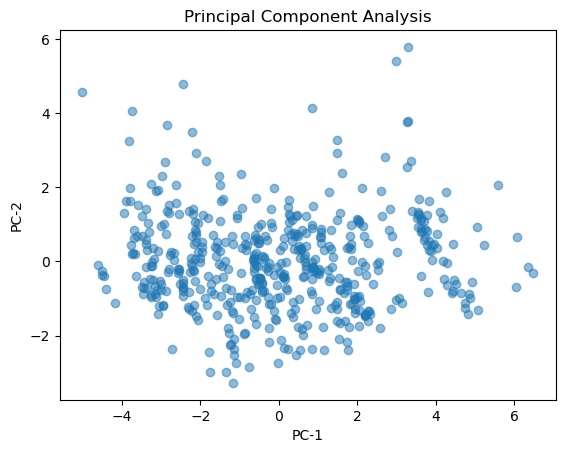

In [31]:
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X_scaled)

#visualize the first two components
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('Principal Component Analysis')

plt.show()

In [17]:
def plot_variance_explained(pca):
    print("Variance explained by each principal component: ")
    print(pca.explained_variance_ratio_[0:10])
    print("Cumulative variance explained by each principal component: ")
    print(np.cumsum(pca.explained_variance_ratio_)[0:10])
    plt.plot(pca.explained_variance_ratio_, marker='o')
    plt.xlabel("number of components")
    plt.ylabel("explained variance ratio")
    plt.show()
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel("number of components")
    plt.ylabel("cumulative explained variance")
    plt.show()

It looks like 2 is the best number of principal components

Variance explained by each principal component: 
[0.46812599 0.14041224 0.12717426 0.09999827]
Cumulative variance explained by each principal component: 
[0.46812599 0.60853822 0.73571248 0.83571075]


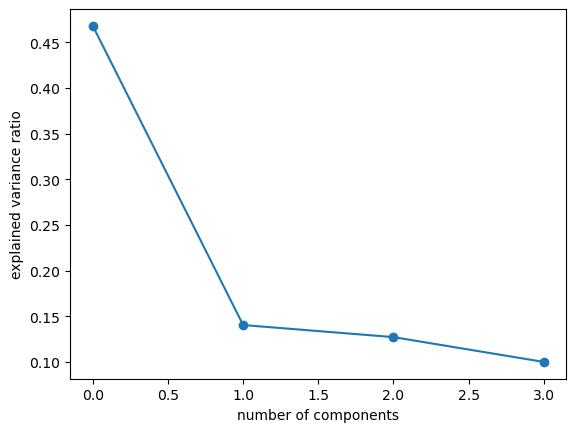

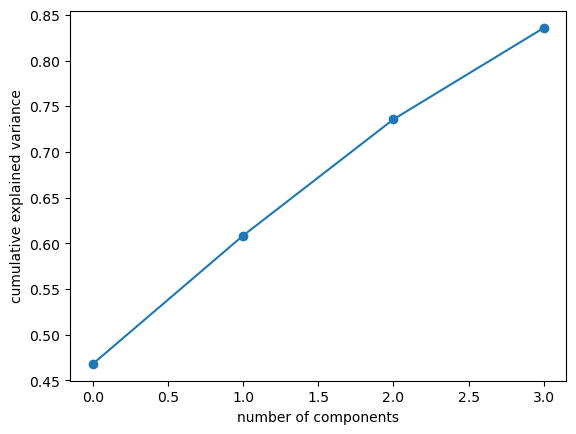

In [18]:
plot_variance_explained(pca)

### t-SNE

t-SNE is an unsupervised learning technique used to for dimensionality reduction. It is a better alternative for non-linear data. Perplexity is the most important hyperparameter in t_SNE. This paramter controls the balance between local and global structure. A high preplexity preseves global structure while a lower perplexity emphasizes local structure.

In [46]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_scaled)

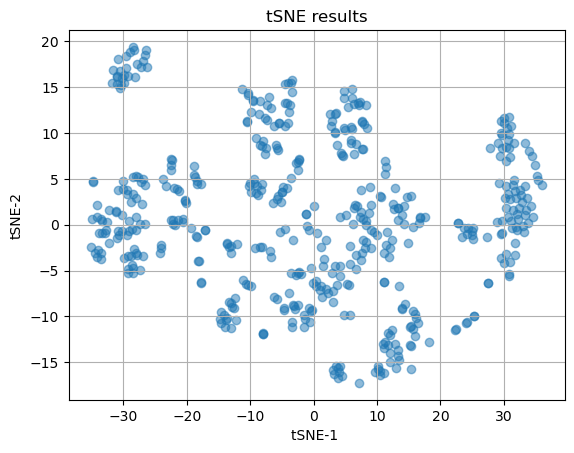

In [47]:
fig, ax = plt.subplots()
ax.scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.5) 
ax.set(xlabel='tSNE-1 ', ylabel='tSNE-2',
title='tSNE results')
ax.grid()
plt.show()

### Kmeans Clustering

Kmeans is another unsupervised learning technique used for clustering. We use the elbow method to find the best number of clusters. We want to choose the number of clusters at the elbow of the graph becasue this indicates that the inertia reduction is decreasing, and there is diminishing returns in adding more clusters. The goal of clustering is to maximize the intercluster distance (distance between clusters - seapartion) and minimize intracluster distance (distance from points to center of cluster - cohesion). The goal is to minimize the variance within each cluster. We can measure how good our clustering is using the silhouette score.


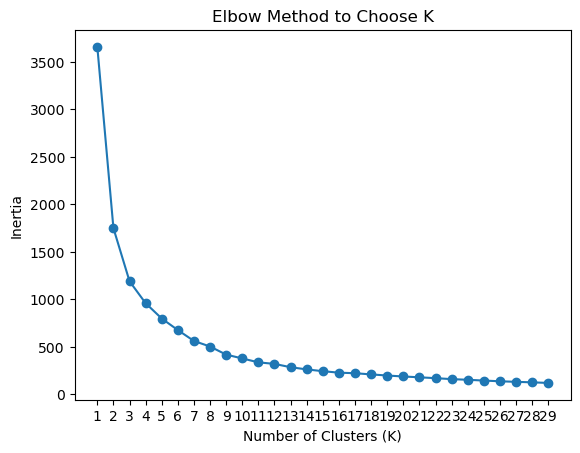

In [69]:
inertia = []
k_values = range(1, 30)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method to Choose K")
plt.xticks(k_values)
plt.show()

We can see that the optimal number of clusters is about 4.

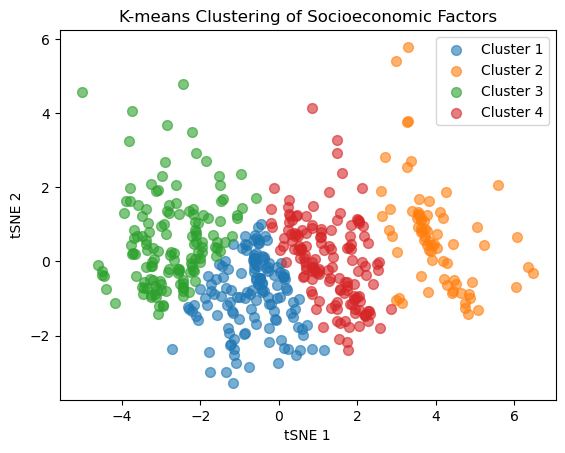

In [70]:
# choose k
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
econ_clusters = kmeans.fit_predict(X_pca)

for cluster in range(n_clusters):
    plt.scatter(X_pca[econ_clusters == cluster, 0], X_pca[econ_clusters == cluster, 1],
        label=f"Cluster {cluster + 1}", s=50, alpha=0.6)

plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.title("K-means Clustering of Socioeconomic Factors")
plt.legend()
plt.show()

In [71]:
cluster_labels = kmeans.labels_

In [72]:

silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.16605649350908025


**Conclusion**: there is not large separation between the clusters, indicating that we may need to use an alternate dimensionality reduction technique

## DBSCAN

DBSCAN is an unsupervised learning clustering algorithm that is better suited for irregular data. It improves upon kmeans because it is able to find non linear clusters. It is also able to identify noise.

In [57]:
dbscan = DBSCAN(eps=0.5, min_samples=3)
dbscan.fit(subset)
df['DBSCAN_Cluster'] = dbscan.labels_

In [58]:
noise_points = df[df['DBSCAN_Cluster'] == -1]


In [60]:
plt.figure(figsize=(10, 6))
plt.scatter(subset[:, 0], subset[:, 1], c=dbscan.labels_, cmap='rainbow', s=20)
plt.title("DBSCAN Clustering")
plt.xlabel("Feature 1 (Standardized)")
plt.ylabel("Feature 2 (Standardized)")
plt.colorbar(label="Cluster Label")
plt.show()


InvalidIndexError: (slice(None, None, None), 0)

<Figure size 1000x600 with 0 Axes>

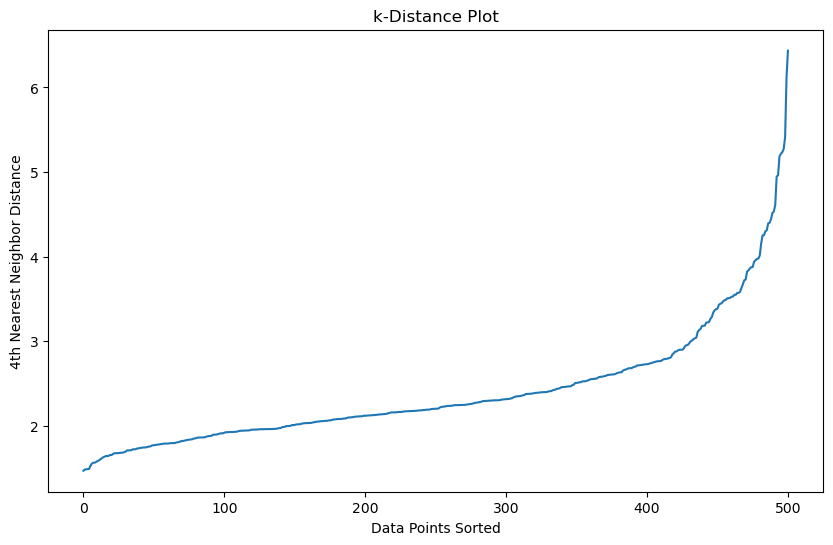

In [92]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances for plotting
distances = np.sort(distances[:, 4], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title("k-Distance Plot")
plt.xlabel("Data Points Sorted")
plt.ylabel("4th Nearest Neighbor Distance")
plt.show()


In [135]:
eps_range = np.arange(0.1, 1.1, 0.1)
min_samples_values = range(2, 20)

results = []

for eps in eps_range:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        if len(set(labels)) > 1: 
            score = silhouette_score(X_scaled, labels)
            results.append((eps, min_samples, score))

In [136]:
results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'silhouette_score'])
best_params = results_df.loc[results_df['silhouette_score'].idxmax()]
best_min_samples = best_params['min_samples']
best_eps = best_params['eps']
print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}")

Best eps: 1.0, Best min_samples: 13.0


In [138]:
clustering = DBSCAN(eps=best_eps, min_samples=int(best_min_samples))
clustering_labels = clustering.fit_predict(X_scaled)

In [ ]:
plot = plt.scatter(df['bill_depth_mm'], df['flipper_length_mm'],c=clustering_labels)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title("DBSCAN Clustering")
unique_labels = np.unique(clustering_labels)
legend_labels = ["Noise" if label == -1 else f"Cluster {label + 1}" for label in unique_labels]
handles, _ = scatter.legend_elements()
plt.legend(handles, legend_labels, title="Clusters")

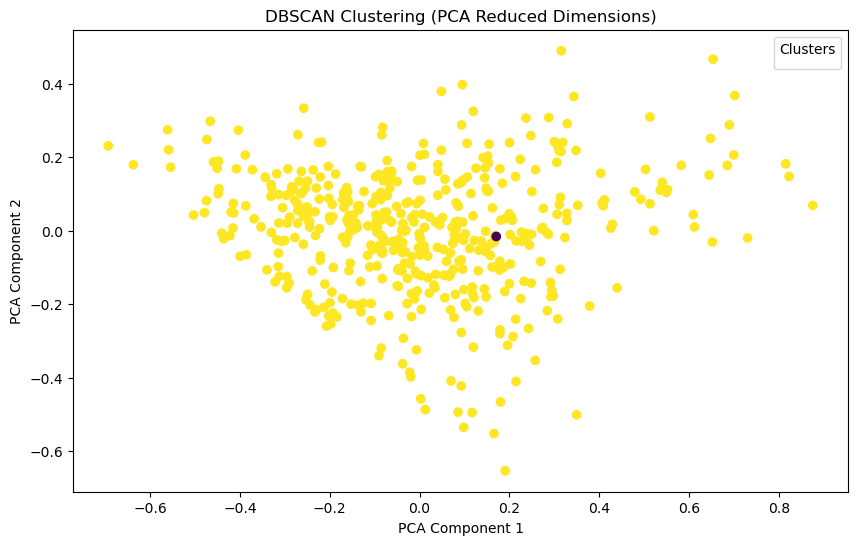

In [53]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_courses)

# Plot the 2D clustering
plt.figure(figsize=(10, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clustering_labels, cmap='viridis')

# Adding labels and title
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title("DBSCAN Clustering (PCA Reduced Dimensions)")

# Add legend for clusters
unique_labels = np.unique(clustering_labels)
legend_labels = ["Noise" if label == -1 else f"Cluster {label + 1}" for label in unique_labels]
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, legend_labels, title="Clusters")

# Show plot
plt.show()


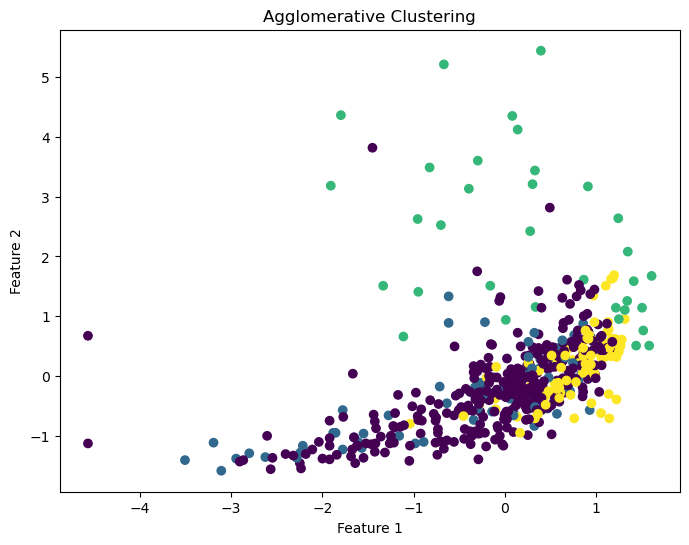

In [63]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs

# Example: Generate synthetic data
X, y = make_blobs(n_samples=300, centers=4, random_state=42)

# Perform Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters=4, linkage='ward')
y_pred = agg_clust.fit_predict(X_scaled)

# Plot the result
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_pred, cmap='viridis')
plt.title('Agglomerative Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [65]:
from scipy.cluster.hierarchy import dendrogram, linkage

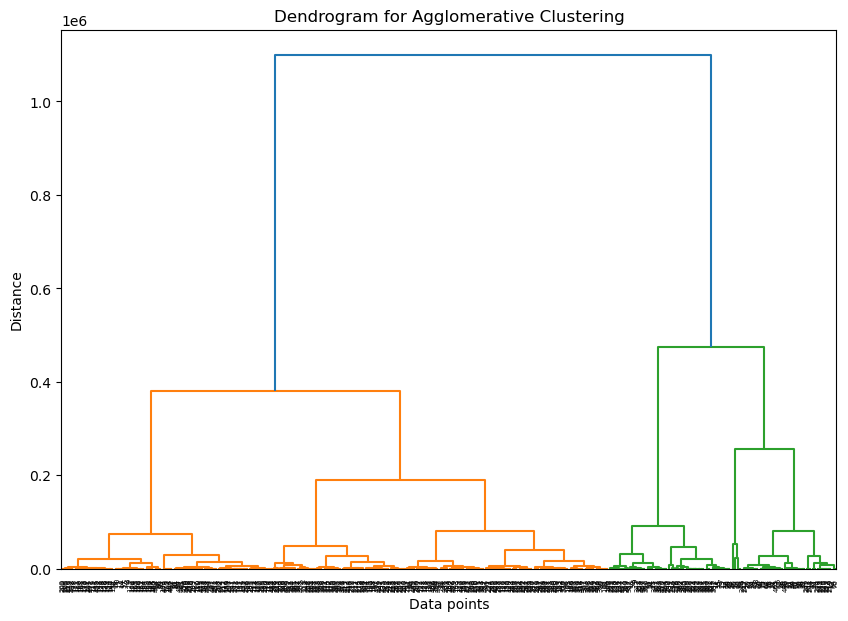

In [67]:
# Perform hierarchical/agglomerative clustering
Z = linkage(subset, 'ward')

# Create a dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Data points')
plt.ylabel('Distance')
plt.show()